In [207]:
import pandas as pd
import numpy as np

In [208]:
data = np.zeros((6,3), dtype=int)

In [209]:
data[:,0] = [0,1,0,1,0,1]
data[0:2,1] = 10
data[2:4,1] = 20
data[4:6,1] = 30
data[:,2] = np.random.randint(0,10,size=6)+57
data

array([[ 0, 10, 63],
       [ 1, 10, 63],
       [ 0, 20, 57],
       [ 1, 20, 59],
       [ 0, 30, 66],
       [ 1, 30, 58]])

In [237]:
df = pd.DataFrame(data, columns = ['SEX', 'FAM', 'Alder'])

In [238]:
df

,SEX,FAM,Alder
0,0,10,63
1,1,10,63
2,0,20,57
3,1,20,59
4,0,30,66
5,1,30,58


In [251]:
ad = np.hstack((np.nan,df['Alder'].to_numpy()))
ad = np.diff(ad)
ad[::2] = ad[1::2]
df['ad'] = ad

In [252]:
df

,SEX,FAM,Alder,ad
0,0,10,63,0.0
1,1,10,63,0.0
2,0,20,57,2.0
3,1,20,59,2.0
4,0,30,66,-8.0
5,1,30,58,-8.0


In [214]:
np.diff(df['Alder'])

array([ 0, -6,  2,  7, -8])

In [213]:
df['ad'] = df.groupby(['FAM']).transform(lambda x: diff(x))['Alder']

NameError: ("name 'diff' is not defined", 'occurred at index SEX')

In [204]:
df

,SEX,FAM,Alder,ad
0,0,10,66,NaN
1,1,10,62,4.0
2,0,20,58,NaN
3,1,20,64,-6.0
4,0,30,59,NaN
5,1,30,63,-4.0


In [205]:
df['ad'][df['ad'].isnull()] = df.groupby(['FAM']).sum().reset_index()['ad']

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [206]:
df

,SEX,FAM,Alder,ad
0,0,10,66,4.0
1,1,10,62,4.0
2,0,20,58,-4.0
3,1,20,64,-6.0
4,0,30,59,NaN
5,1,30,63,-4.0


In [199]:
df.groupby(['FAM']).sum()

,SEX,Alder,ad
FAM,,,
10,1,128,-2.0
20,1,122,-4.0
30,1,122,0.0


In [14]:
df.groupby(['FAM']).sum().reset_index()['ad']

0    0.0
1    5.0
2   -3.0
Name: ad, dtype: float64

In [8]:
df.groupby(['FAM']).transform(lambda x: x.shift(-1))

,SEX,Alder,ad
0,1.0,59.0,0.0
1,NaN,NaN,NaN
2,1.0,59.0,5.0
3,NaN,NaN,NaN
4,1.0,63.0,-3.0
5,NaN,NaN,NaN


In [173]:
df['ad'] = df.groupby(['FAM']).transform(lambda x: x.shift(-1))

In [174]:
df

,SEX,FAM,Alder,ad
0,0,10,64,1.0
1,1,10,66,NaN
2,0,20,57,1.0
3,1,20,60,NaN
4,0,30,60,1.0
5,1,30,60,NaN


In [157]:
df.loc[df['ad'].isnull(),'ad'] = df.groupby(['FAM']).sum().reset_index()['ad']

In [158]:
df

,SEX,FAM,Alder,ad
0,0,10,64,-2.0
1,1,10,66,-2.0
2,0,20,57,0.0
3,1,20,60,-3.0
4,0,30,60,NaN
5,1,30,60,0.0


In [159]:
df.groupby(['FAM']).sum().reset_index()['ad']

0   -4.0
1   -3.0
2    0.0
Name: ad, dtype: float64

In [147]:
df

,SEX,FAM,Alder,ad
0,0,10,64,NaN
1,1,10,66,-2.0
2,0,20,57,NaN
3,1,20,60,-3.0
4,0,30,60,NaN
5,1,30,60,0.0


In [111]:
idx = df['ad'].isnull()

In [112]:
df[idx

0     True
1    False
2     True
3    False
4     True
5    False
Name: ad, dtype: bool

In [109]:
df.groupby(['FAM']).sum()['ad']

FAM
10   -2.0
20   -3.0
30    0.0
Name: ad, dtype: float64

In [98]:
df.groupby(['FAM']).sum()['ad']

FAM
10   -5.0
20   -3.0
30   -5.0
Name: ad, dtype: float64

In [69]:
df['Alder_h'] = df['Alder']*(df['SEX']==1)
df['Alder_w'] = df['Alder']*(df['SEX']==0)

In [72]:
df.groupby(['FAM','SEX']).sum()

Alder  Alder_h  Alder_w
FAM SEX                         
10  0       66        0       66
    1       65       65        0
20  0       61        0       61
    1       63       63        0
30  0       66        0       66
    1       58       58        0

In [64]:
df.groupby(['FAM','SEX']).mean()

Alder
FAM SEX       
10  0       66
    1       65
20  0       61
    1       63
30  0       66
    1       58

In [197]:
df['d'] = df['Age']*df['ELIG']+1000*(1-df['ELIG'])
new = df[['PNR', 'd']].groupby(['PNR']).min().reset_index()
df = pd.merge(df.drop(['d'],axis=1),new)
df['d'] = np.where(df['d']==1000,0,df['d'])

In [201]:
d57 = df[(df['Age'] == 57)]

In [215]:
df[df['Age'] == 57]

,PNR,Age,PRE_SOCIO,ELIG,d
0,1,57,322,1,57
5,2,57,322,0,0
10,3,57,322,0,60


In [216]:
np.std([1,0,0])

0.4714045207910317

In [242]:
def ret(df,ret_age):
    tmp = df[df['Age'] == ret_age]
    tæller = np.sum(tmp['d'] == ret_age)
    nævner = len(tmp)
    std = np.std(np.where(tmp['d']==ret_age,1,0))
    return tæller/nævner,std

In [244]:
for ret_age in range(57,62):
    print(ret(df,ret_age))

(0.3333333333333333, 0.4714045207910317)
(0.0, 0.0)
(0.0, 0.0)
(0.5, 0.5)
(0.0, 0.0)


In [210]:
ret(df,60)

0.5

In [205]:
np.sum(d57['d'] == 57)/len(d57)

0.3333333333333333

0      True
1     False
2     False
3     False
4     False
5      True
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
Name: Age, dtype: bool

In [168]:
df.drop(['d'],axis=1)

,PNR,Age,PRE_SOCIO,ELIG
0,1,57,322,1
1,1,58,322,1
2,1,59,322,0
3,1,60,322,0
4,1,61,322,0
5,2,57,322,0
6,2,58,322,0
7,2,62,322,0
8,2,63,322,0
9,2,64,322,0


In [166]:
new

,PNR,Age,PRE_SOCIO,ELIG,d
0,1,57,322,1,57
1,3,60,322,1,60


In [153]:
df

,PNR,Age,PRE_SOCIO,ELIG,d
0,1,57,322,1,57
1,1,58,322,1,58
2,1,59,322,0,0
3,1,60,322,0,0
4,1,61,322,0,0
5,2,57,322,0,0
6,2,58,322,0,0
7,2,62,322,0,0
8,2,63,322,0,0
9,2,64,322,0,0


In [128]:
new_elig = df[['PNR', 'd']].groupby(['PNR']).min().reset_index()
new = pd.merge(df, new_elig)

In [125]:
new_elig

,PNR,d
0,1,0
1,2,0
2,3,0


In [124]:
new

,PNR,Age,PRE_SOCIO,ELIG,d
0,1,59,322,0,0
1,1,60,322,0,0
2,1,61,322,0,0
3,2,57,322,0,0
4,2,58,322,0,0
5,2,62,322,0,0
6,2,63,322,0,0
7,2,64,322,0,0
8,3,57,322,0,0
9,3,58,322,0,0


In [ ]:
new = pd.merge(df.drop(['ELIG'],axis=1,
               df[[]]))

In [65]:
test = df[['PNR', 'ELIG']].groupby(['PNR']).max().reset_index()

In [74]:
df.drop(['ELIG'],axis=1)

,PNR,Age,PRE_SOCIO
0,1,57,322
1,1,58,322
2,1,59,322
3,1,60,322
4,1,61,322
5,2,57,322
6,2,58,322
7,2,62,322
8,2,63,322
9,2,64,322


In [69]:
new = pd.merge(df,test)

In [70]:
new

,PNR,Age,PRE_SOCIO,ELIG,ELIG_NEW
0,1,57,322,1,1
1,1,58,322,1,1
2,1,59,322,0,1
3,1,60,322,0,1
4,1,61,322,0,1
5,2,57,322,0,0
6,2,58,322,0,0
7,2,62,322,0,0
8,2,63,322,0,0
9,2,64,322,0,0


In [52]:
test['PNR']

0    1
1    2
2    3
Name: PNR, dtype: int64

In [59]:
df['PNR']

0     1
1     1
2     1
3     1
4     1
5     2
6     2
7     2
8     2
9     2
10    3
11    3
12    3
13    3
14    3
Name: PNR, dtype: int32

In [53]:
df['PNR'] == test['PNR']

ValueError: Can only compare identically-labeled Series objects

In [42]:
df

,PNR,Age,PRE_SOCIO,ELIG
0,1,57,322,NaN
1,1,58,322,1.0
2,1,59,322,0.0
3,1,60,322,0.0
4,1,61,322,NaN
5,2,57,322,NaN
6,2,58,322,NaN
7,2,62,322,NaN
8,2,63,322,NaN
9,2,64,322,NaN


In [38]:
df['ELIG'] = df.groupby(['PNR', 'Age']).max()['ELIG']

TypeError: incompatible index of inserted column with frame index

In [36]:
df

,PNR,Age,PRE_SOCIO,ELIG
0,1,57,322,1
1,1,58,322,1
2,1,59,322,0
3,1,60,322,0
4,1,61,322,0
5,2,57,322,0
6,2,58,322,0
7,2,62,322,0
8,2,63,322,0
9,2,64,322,0


In [12]:
np.where((df['Age'] == 57) & (df['ELIG'] == 1), 'yes', 'no')

array(['yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no'], dtype='<U3')

In [23]:
cond = (df['Age'] == 57) & (df['ELIG'] == 1)

In [24]:
np.select([cond], [3], default=1)

array([3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
cond = ['PNR' == 1]
np.select(df)

TypeError: select() missing 1 required positional argument: 'choicelist'

In [5]:
df

,PNR,Age,PRE_SOCIO,ELIG
0,1,57,322,1
1,1,58,322,1
2,1,59,322,0
3,1,60,322,0
4,1,61,322,0
5,2,57,322,0
6,2,58,322,0
7,2,62,322,0
8,2,63,322,0
9,2,64,322,0


Drop missing observations for age

In [6]:
mask = np.zeros(len(df), dtype=bool)
for i in df['PNR'].unique():
    idx = df[df['PNR']==i].index.tolist()
    df_tmp = df.loc[idx]
    age_diff = df_tmp['Age'].diff()
    age_dummy = np.all((age_diff == 1) | (np.isnan(age_diff)))
    soc_dummy = np.all(df_tmp['PRE_SOCIO'].isin([130, 322, 333]))
    mask[idx] = np.all([age_dummy, soc_dummy])
    
df = df[mask].reset_index(drop=True)

In [7]:
df

,PNR,Age,PRE_SOCIO,ELIG
0,1,57,322,1
1,1,58,322,1
2,1,59,322,0
3,1,60,322,0
4,1,61,322,0


In [8]:
for i in df['PNR'].unique():
    idx = df[df['PNR']==i].index.tolist()
    df.loc[idx,'ELIG'] = np.any(df.loc[idx,'ELIG']==1)*1

In [9]:
df

,PNR,Age,PRE_SOCIO,ELIG
0,1,57,322,1
1,1,58,322,1
2,1,59,322,1
3,1,60,322,1
4,1,61,322,1


In [79]:
df

,PNR,Age,PRE_SOCIO,ELIG
0,1,57,322,1
1,1,58,322,1
2,1,59,322,1
3,1,60,322,1
4,1,61,322,1


In [71]:


df

,PNR,Age,PRE_SOCIO,ELIG
0,1,57,322,1
1,1,58,322,1
2,1,59,322,0
3,1,60,322,0
4,1,61,322,0


,PNR,Age
0,1,57
1,1,58
2,1,59
3,1,60
4,1,61
5,3,57
6,3,58
7,3,59
8,3,60
9,3,61


In [184]:
idx

[10, 11, 12, 13, 14]

In [171]:
len(df)

15

In [170]:
mask

True

In [165]:
mask = (df['Age'].diff() == 1) | (np.isnan(df['Age'].diff()))

In [168]:
mask

0      True
1      True
2      True
3      True
4      True
5     False
6      True
7     False
8      True
9      True
10    False
11     True
12     True
13     True
14     True
Name: Age, dtype: bool

In [156]:
df['dummy'] = False

In [158]:
df.loc[df[(df['PNR']==1) & (df['Age']>59)].index,'dummy'] = False

In [162]:
df.loc[df[df['PNR']==1].index,'Age']

0    57
1    58
2    59
3    60
4    61
Name: Age, dtype: int32

In [159]:
df

,PNR,Age,dummy
0,1,57,False
1,1,58,False
2,1,59,False
3,1,60,False
4,1,61,False
5,2,57,False
6,2,58,False
7,2,62,False
8,2,63,False
9,2,64,False


In [119]:
for i in df['PNR'].unique():
    df[(df['PNR']==i) & (df['']==)]

,PNR,Age,dummy
0,1,57,False
1,1,58,False
2,1,59,False
3,1,60,False
4,1,61,False
5,2,57,False
6,2,58,False
7,2,62,False
8,2,63,False
9,2,64,False


In [115]:
df['dummy'] = (df['Age'].diff() == 1) | (np.isnan(df['Age'].diff()))

In [116]:
df

,PNR,Age,dummy
0,1,57,True
1,1,58,True
2,1,59,True
3,1,60,True
4,1,61,True
5,2,57,False
6,2,58,True
7,2,62,False
8,2,63,True
9,2,64,True


In [74]:
df.groupby('PNR').filter(lambda x: len(x)>0)

,PNR,Age
0,1,57
1,1,58
2,1,59
3,1,60
4,1,61
5,2,57
6,2,58
7,2,62
8,2,63
9,2,64


In [99]:
(df['Age'].diff() == 1) | (np.isnan(df['Age'].diff()))

0     True
1     True
2     True
3     True
4     True
5    False
6     True
7    False
8     True
9     True
Name: Age, dtype: bool

In [87]:
df['PNR'].value_counts()

2    5
1    5
Name: PNR, dtype: int64

In [77]:
my_df = pd.DataFrame({'A':[1,2,4],'B':[1,1,1],'C':[3,2,1]})

In [78]:
my_df.apply(lambda x: x.is_monotonic)

A     True
B     True
C    False
dtype: bool

In [66]:
for i in df['PNR'].unique():
    print(i)

1
2


In [67]:
for i in df['PNR'].unique():
    df['PNR'] == i

In [68]:
df

,PNR,Age
0,1,57
1,1,58
2,1,59
3,1,60
4,1,61
5,2,57
6,2,58
7,2,62
8,2,63
9,2,64


In [64]:
df[df['PNR'] == 1]

,PNR,Age
0,1,57
1,1,58
2,1,59
3,1,60
4,1,61


In [11]:
np.array(data).shape

(2, 2)

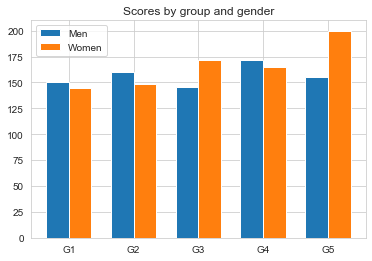

In [267]:
import numpy as np
import matplotlib.pyplot as plt


N = 5
menMeans = (150, 160, 146, 172, 155)

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, menMeans, width)


womenMeans = (145, 149, 172, 165, 200)
p2 = ax.bar(ind + width, womenMeans, width)

ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((p1[0], p2[0]), ('Men', 'Women'))
#ax.yaxis.set_units(inch)
ax.autoscale_view()

plt.show()

In [261]:
ind

array([0, 1, 2, 3, 4])

In [147]:
import seaborn as sns
sns.set_style("whitegrid")

In [306]:
AD = np.random.uniform(-0.2,0.2,size=(9,11))
AD[4,8] = np.nan
AD[2,7] = np.nan
AD[0,0] = np.nan
AD[0,8] = np.nan

In [311]:
def ModelFitAD(AD, ages=np.arange(58,69)):
    fig, axs = plt.subplots(3,3, figsize=(6*2,4*2), sharey=True, sharex=True)
    axs = axs.flatten()
    index = np.arange(len(ages))
    width=0.35
    plt.setp(axs, xticks=index+width/2, xticklabels=ages, ylim=[-0.2,0.2])
    for j in range(9):
        axs[j].bar(index+width,AD[j],width,color='red',label='Men')
        axs[j].bar(index,AD[j],width,color='black',label='Women')
        axs[j].set_title(f"$\Delta$age = {j-4}")
        
    fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
    axs[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)

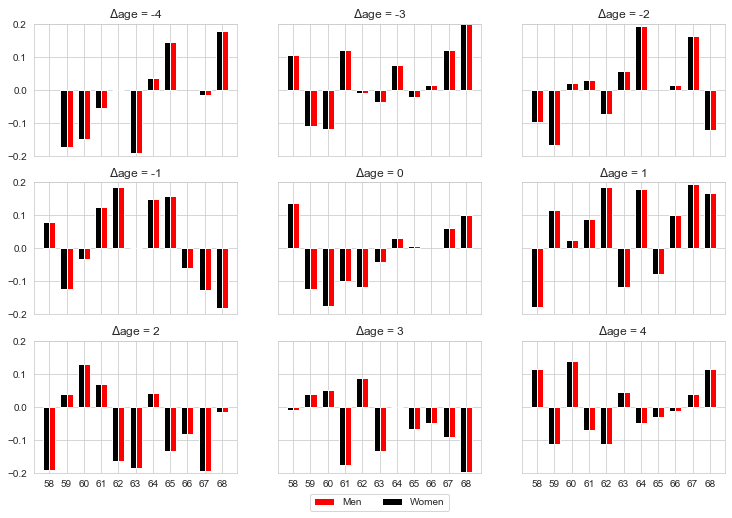

In [312]:
ModelFitAD(AD)

In [122]:
print(plt.rcParams.get('subplots.figsize'))

None


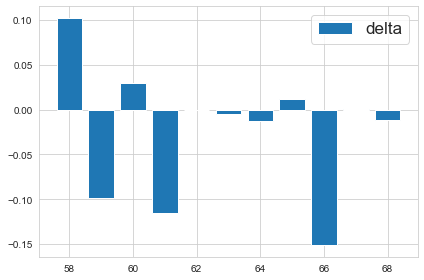

In [117]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.bar(index,ad_4,label='delta')
ax.legend(fontsize=fs)

fig.tight_layout()

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.optimize import minimize, differential_evolution
from numba import njit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [16]:
#@njit(parallel=True)
def f(x):
    return g(x)
    
#@njit(parallel=True)
def f_arr(X):
    Y = np.empty(X.shape)
    for i in range(X.size):
        Y[i] = g(X[i])
    return Y

#@njit(parallel=True)
def g(x):
    if x<-1:
        return 2+x
    elif -1<=x<=1:
        return abs(x)
    elif 1<x<2:
        return 2-x
    elif x>=2:
        return x-1    

In [122]:
def beale(x1,x2):
    return (1.5-x1+x1*x2)**2 + (2.25-x1+x1*(x2**2))**2 + (2.625-x1+x1*(x2)**3)**2

def ackley(x1,x2):
    return -20*np.exp(-0.2*np.sqrt(0.5*(x1**2 + x2**2))) - np.exp(0.5*(np.cos(2*np.pi*x1) + np.cos(2*np.pi*x2))) + np.e + 20

def bukin(x1,x2):
    return 100*np.sqrt(abs(x2 - 0.01*(x1**2)) + 0.01*abs(x1+10))

def obj(X):
    x1 = X[0]
    x2 = X[1]
    #return beale(x1,x2)
    return ackley(x1,x2)
    #return bukin(x1,x2)

In [123]:
x1 = np.linspace(-32.768, 32,768, 100)
x2 = x1
#x1 = np.linspace(-15,-5, 100)
#x2 = np.linspace(-3,3, 100)
x1,x2 = np.meshgrid(x1,x2)

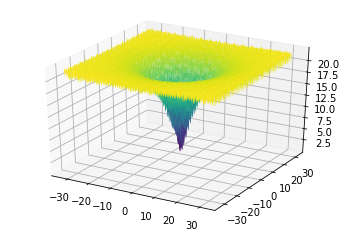

In [124]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1,x2,ackley(x1,x2), cmap='viridis')

In [145]:
bounds = [(-5,5), (-5,5)]
differential_evolution(obj,bounds)

     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 3183
     nit: 103
 success: True
       x: array([0., 0.])

In [127]:
method = 'nelder-mead'
options = {'disp': False}
theta0 = (10,10)
minimize(obj,theta0, method=method, options=options)

 final_simplex: (array([[9.99495262, 9.99495206],
       [9.99488681, 9.99494303],
       [9.99490253, 9.99488858]]), array([17.2919271 , 17.2919272 , 17.29192725]))
           fun: 17.291927104282813
       message: 'Optimization terminated successfully.'
          nfev: 57
           nit: 29
        status: 0
       success: True
             x: array([9.99495262, 9.99495206])

In [134]:
feval = []
theta0 = np.array([2,-2])
for i in range(30):
    info = minimize(obj,theta0, method=method, options=options)
    feval.append(info.nfev)
    theta0 = info.x
    print(info.x)
print(feval)

[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[ 1.97442506 -1.97445789]
[52, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]


In [110]:
sum(feval[0:5])

2003

In [83]:
info

 final_simplex: (array([[9.99495262, 9.99495206],
       [9.9949061 , 9.99497252],
       [9.99489409, 9.99489781]]), array([17.2919271 , 17.29192717, 17.29192724]))
           fun: 17.291927104282813
       message: 'Optimization terminated successfully.'
          nfev: 60
           nit: 32
        status: 0
       success: True
             x: array([9.99495262, 9.99495206])

In [79]:
info.x

array([9.99495262, 9.99495206])

In [76]:
info.x-[0,0]

array([9.99495262, 9.99495206])

In [57]:
info.x

array([2.9999593 , 0.49998973])

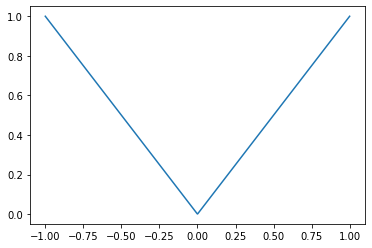

In [14]:
x = np.linspace(-1,1,1000)
plt.plot(x,f_arr(x))

In [26]:
from sklearn.model_selection import ParameterGrid

In [27]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [28]:
param_grid

[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
 {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}]

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import funs
import figs
import transitions
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

In [2]:
def mom_fun(sim,moments=True):
    
    # unpack
    states = np.unique(sim.states,axis=0)
    MA = sim.states[:,0]
    ST = sim.states[:,1]    
    probs = sim.probs[:,1:,0]*100 # 1: means exclude age 57 (since first prob is at 58)
        
    # initialize
    T = probs.shape[1]
    N = len(states)
    mom = np.zeros((T,N))
    
    # compute moments
    for i in range(N):
        ma = states[i,0]
        st = states[i,1]
        idx = np.nonzero((MA==ma) & (ST==st))[0]
        if moments:
            mom[:,i] = np.nanmean(probs[idx,:],axis=0)
        else:
            mom[:,i] = np.nanstd(probs[idx,:],axis=0)
    return mom.ravel()

def mom_fun_total(sim):
    
    # unpack
    probs = sim.probs[:,1:,0]*100
    MA = [0, 1, np.array([0,1])] # women, men and both
    
    # initialize
    T = probs.shape[1]
    N = len(MA)
    mom = np.zeros((T,N))
    
    for i in range(N):
        idx = np.nonzero(np.isin(sim.states[:,0],MA[i]))[0]
        mom[:,i] = np.nanmean(probs[idx,:],axis=0)
    return mom.ravel(order='F')

def weight_matrix(std):
    std_inv = np.zeros(std.shape)
    idx = np.nonzero(std>0)[0]
    std_inv[idx] = 1/std[idx]
    return np.eye(std.size)*std_inv

In [3]:
data_seed = 1000
model = RetirementClass(sim_seed = data_seed)
model.par.simT = 12
model.solve() # jit function
model.simulate() # jit function

In [4]:
mom_data = mom_fun(model.sim)
mom_se = mom_fun(model.sim,moments=False)
W = weight_matrix(mom_se)

In [5]:
model.par.Na = 100
model.par.var_men = 0.0
model.par.var_women = 0.0
model.par.Nxi = 1
model.par.simN = 10000
est_seed = 200
model.par.sim_seed = est_seed
model.solve(recompute=True)
model.par.simT = 12
model.simulate(recompute=True)

In [6]:
#model.par.alpha_0_female = 0.160
#model.par.alpha_1 = 0.053
#model.par.sigma_eta = 0.435

In [56]:
# Parameters to be estimated (and guess)
true = [0.160, 0.160, 0.053, 0.435]
theta0 = [2,2,2,1]
add_str = '_est'
est_par = ["alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta"]

# Setup estimation
smd_base = SMD.SimulatedMinimumDistance(model,mom_data,mom_fun,print_iter=[True,50],save=True,options={'disp':True, 'xatol':0.001, 'fatol':0.001})
smd_base.est_par = est_par
smd_base.est_par_save = {'{}'.format(i):[] for i in est_par}
smd_base.est_par_save['obj_func'] = []

In [57]:
#guess = [[-1,-1,-1,1], [-0.5,-0.5,-0.5,1], [0.1,0.1,0.1,1], [0.5,0.5,0.5,1], [1,1,1,1], [2,2,2,1]]
#smd_base.multistart_estimate(guess,W)

In [58]:
tic = time.time()
for i in range(5):
    smd_base.estimate(theta0,W)
    theta_base = smd_base.est
    theta0 = theta_base
toc = time.time()

Iteration: 50 (0.19 minutes)
 alpha_0_male=-1.0012 alpha_0_female=-1.4641 alpha_1=-19.6119 sigma_eta=8.0239 -> 1802.7077
Iteration: 100 (0.11 minutes)
 alpha_0_male=0.2819 alpha_0_female=0.8184 alpha_1=-0.3747 sigma_eta=2.3995 -> 1303.0234
Iteration: 150 (0.12 minutes)
 alpha_0_male=0.2586 alpha_0_female=0.3652 alpha_1=-0.2738 sigma_eta=2.6867 -> 936.4376
Iteration: 200 (0.12 minutes)
 alpha_0_male=0.2899 alpha_0_female=0.3736 alpha_1=-0.3217 sigma_eta=2.6790 -> 927.4025
Iteration: 250 (0.16 minutes)
 alpha_0_male=0.2903 alpha_0_female=0.3718 alpha_1=-0.3152 sigma_eta=2.6786 -> 927.9950
Iteration: 300 (0.12 minutes)
 alpha_0_male=0.2888 alpha_0_female=0.3723 alpha_1=-0.3163 sigma_eta=2.6749 -> 925.1761
Iteration: 350 (0.11 minutes)
 alpha_0_male=0.1848 alpha_0_female=0.4113 alpha_1=-0.3963 sigma_eta=2.3960 -> 886.5875
Iteration: 400 (0.12 minutes)
 alpha_0_male=0.1844 alpha_0_female=0.4116 alpha_1=-0.3969 sigma_eta=2.3940 -> 886.3347
Iteration: 450 (0.12 minutes)
 alpha_0_male=0.1848 a

In [59]:
print('Parameter:                ', est_par)
print('True:                     ', np.round(true, 4))
print('Estimated:                ', np.round(theta_base, 4))
print('bias:                     ', np.round(theta_base-true, 4))
print('relative bias:            ', np.round((theta_base/true-1)*100, 1))
print('Estimation time:          ', round((toc-tic)/60,2), 'minutes')

Parameter:                 ['alpha_0_male', 'alpha_0_female', 'alpha_1', 'sigma_eta']
True:                      [0.16  0.16  0.053 0.435]
Estimated:                 [0.1852 0.1828 0.0562 0.4026]
bias:                      [ 0.0252  0.0228  0.0032 -0.0324]
relative bias:             [15.8 14.3  6.1 -7.5]
Estimation time:           2.86 minutes


In [19]:
print('Parameter:                ', est_par)
print('True:                     ', np.round(true, 4))
print('Estimated:                ', np.round(theta_base, 4))
print('bias:                     ', np.round(theta_base-true, 4))
print('relative bias:            ', np.round((theta_base/true-1)*100, 1))
print('Estimation time:          ', round((toc-tic)/60,2), 'minutes')

Parameter:                 ['alpha_0_male', 'alpha_0_female', 'alpha_1', 'sigma_eta']
True:                      [0.2035 0.1841 0.0301 0.4208]
Estimated:                 [0.1674 0.1636 0.0833 0.3555]
bias:                      [-0.0361 -0.0204  0.0531 -0.0653]
relative bias:             [-17.7 -11.1 176.3 -15.5]
Estimation time:           0.87 minutes


In [ ]:
def obj_temp(model,theta,W,mom_data):
    model.par.alpha_0_male = theta[0]
    model.par.alpha_0_female = theta[1]
    model.par.alpha_1 = theta[2]
    model.par.sigma_eta = theta[3]
    model.solve()
    model.simulate()
    mom_sim = mom_fun(model.sim)
    diff = mom_data - mom_sim
    return (np.transpose(diff) @ W) @ diff

def obj(theta):
    return obj_temp(model,theta,W,mom_data)

In [133]:
x[0].size

225

In [141]:
x4

array([0.01, 0.63, 1.25])

In [145]:
x1 = np.linspace(-0.25,0.25,5)
x2 = np.linspace(-0.25,0.25,5)
x3 = np.linspace(-0.2,0.2,3)
x4 = np.linspace(0.2,0.6,3)
x = np.meshgrid(x1,x2,x3,x4)
X1 = []
X2 = []
X3 = []
X4 = []
Y = []
for i in range(x[0].size):
    X1.append(x[0].ravel()[i])
    X2.append(x[1].ravel()[i])
    X3.append(x[2].ravel()[i])
    X4.append(x[3].ravel()[i])    
    Y.append(obj([x[0].ravel()[i], x[1].ravel()[i], x[2].ravel()[i], x[3].ravel()[i]]))

In [150]:
idx = np.argmin(Y)
print(X1[idx])
print(X2[idx])
print(X3[idx])
print(X4[idx])
print(np.min(Y))

0.25
0.25
0.0
0.6
52.57038559432226


In [2]:
(30000/60)/60

8.333333333333334

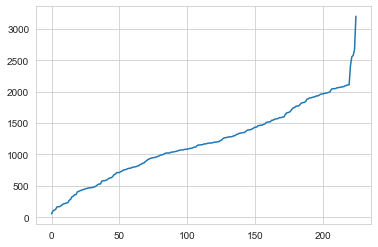

In [147]:
plt.plot(np.sort(Y))

In [67]:
x1 = np.linspace(-0.2,0.2,5)
x2
F = []
X = []
for i in range(len(x)):
    X.append(x[i])
    F.append(obj([x[i]]))

In [68]:
x

array([-0.2, -0.1,  0. ,  0.1,  0.2])

(0, 5000)

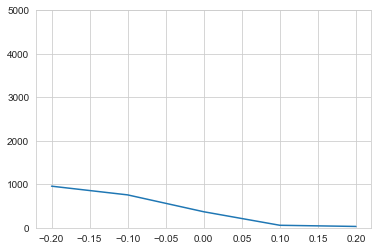

In [69]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(X,F)
ax.set_ylim(0,5000)

In [38]:
obj([0.16])

5.653963674889211

In [ ]:
store = []
for i in 

In [162]:
from skopt import gp_minimize, dummy_minimize, forest_minimize
from skopt.space import Real
space = [Real(-5,5,'uniform'),
         Real(-5,5,'uniform'),
         Real(-5,5,'uniform'),
         Real(0.02,2,'uniform')]
res = gp_minimize(obj, space, n_calls=25, noise=[1e-10], random_state=0)
#res = dummy_minimize(obj, space, n_calls=225, random_state=0)
#res = forest_minimize(obj, space, n_calls=500, random_state=0)

In [163]:
print('estimated', res.x)
print('bias', res.x - np.array([0.160, 0.160, 0.053, 0.435]))
print(obj(res.x))

estimated [0.2948133447596586, -0.16605446298776805, -2.9873245138083098, 1.1386209327739294]
bias [ 0.13481 -0.32605 -3.04032  0.70362]
1177.1201008703847


In [167]:
res.x[0]*0.5

0.1474066723798293

In [159]:
from skopt import gp_minimize, dummy_minimize, forest_minimize
from skopt.space import Real
space = [Real(-0.5+res.x[0],0.5,'uniform'),
         Real(-0.5,0.5,'uniform'),
         Real(-0.5,0.5,'uniform'),
         Real(0.5,0.5,'uniform')]
res = gp_minimize(obj, space, n_calls=25, noise=[1e-10], random_state=0)
#res = dummy_minimize(obj, space, n_calls=225, random_state=0)
#res = forest_minimize(obj, space, n_calls=500, random_state=0)

In [160]:
print('estimated', res.x)
print('bias', res.x - np.array([0.160, 0.160, 0.053, 0.435]))
print(obj(res.x))

estimated [0.1648806300295273, 0.17390800136229967, 0.03841705527811903, 0.4797685412823352]
bias [ 0.00488  0.01391 -0.01458  0.04477]
10.558969778596435


In [152]:
print('estimated', res.x)
print('bias', res.x - np.array([0.160, 0.160, 0.053, 0.435]))
print(obj(res.x))

estimated [0.1365174880849117, 0.12329214410020639, 0.08857204405688246, 0.393156649032516]
bias [-0.02348251 -0.03670786  0.03557204 -0.04184335]
21.387387400265226


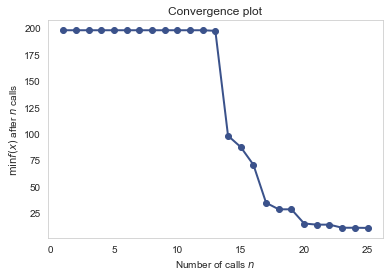

In [161]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [33]:
from skopt import gp_minimize

def f(x,theta,W):
    #return (np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) +
    #        np.random.randn() * 0.1)
    return (x[0] + theta)**2 - W

def ff(x):
    return f(x,theta,W)

res = gp_minimize(ff, [(-20.0, 20.0)], n_calls=50, random_state=0)

In [55]:
res.x[0]

-0.22334882678650025

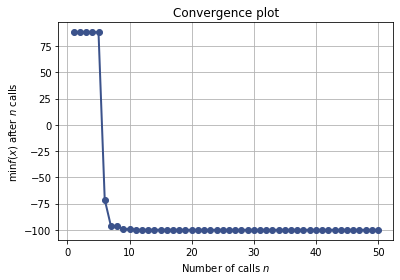

In [35]:
from skopt.plots import plot_convergence

plot_convergence(res)

In [3]:
from skopt.space import Real
from skopt.utils import use_named_args

@use_named_args(space)
def objective(**params):
    return (x)**2

ModuleNotFoundError: No module named 'skopt'

# Setup

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

In [2]:
%matplotlib inline
# reload module each time cell is run
%load_ext autoreload
%autoreload 2
from ModelSingles import SingleClass
#from ModelCouples import CoupleClass
import numpy as np
import matplotlib.pyplot as plt
import funs
import figs

In [3]:
# Test that numba is working
# It should throw an error
from numba import njit, typeof
@njit(parallel=True)
def test():
    return [1, [2]]
test()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mType of variable '$0.4' cannot be determined, operation: build_list(items=[Var($const0.1, <ipython-input-3-ff937188aec6> (6)), Var($0.3, <ipython-input-3-ff937188aec6> (6))]), location: <ipython-input-3-ff937188aec6> (6)
[1m
File "<ipython-input-3-ff937188aec6>", line 6:[0m
[1mdef test():
[1m    return [1, [2]]
[0m    [1m^[0m[0m
[0m
This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


# Estimation

In [96]:
import SimulatedMinimumDistance as SMD

Moment and weight functions

In [124]:
def mom_fun(data):
    mask_mh = (data.states==6) | (data.states==8)
    mask_ml = (data.states==5) | (data.states==7)
    mask_fh = (data.states==1) | (data.states==3)
    mask_fl = (data.states==0) | (data.states==2)
    return np.hstack((np.nanmean(data.probs[:,mask_mh],axis=1),
                      np.nanmean(data.probs[:,mask_ml],axis=1),
                      np.nanmean(data.probs[:,mask_fh],axis=1),
                      np.nanmean(data.probs[:,mask_fl],axis=1)
                    ))*100

def weight_fun(data):
    mask_mh = (data.states==6) | (data.states==8)
    mask_ml = (data.states==5) | (data.states==7)
    mask_fh = (data.states==1) | (data.states==3)
    mask_fl = (data.states==0) | (data.states==2)
    std = np.hstack((np.nanstd(data.probs[:,mask_mh]*100,axis=1),
                     np.nanstd(data.probs[:,mask_ml]*100,axis=1),
                     np.nanstd(data.probs[:,mask_fh]*100,axis=1),
                     np.nanstd(data.probs[:,mask_fl]*100,axis=1)
                    ))
    return np.eye(len(std))*std

Create simulated data

In [123]:
data = SingleClass(Na=190, poc=10, a_max=10, simN=40000, simT=20)
data.par.simStates = np.array(list(range(8))*5000)
data.solve()
data.simulate()

In [125]:
mom_data = mom_fun(data.sim)
weight = weight_fun(data.sim)

Preparing for estimation

In [126]:
true = [data.par.alpha_0_female, data.par.alpha_0_male, data.par.alpha_1]
theta0 = [i*1.5 for i in true]
add_str = '_est'
est_par = ("alpha_0_female", "alpha_0_male", "alpha_1") # remember to be list if only 1 var

In [127]:
model_base = SingleClass(Na=190, poc=10, a_max=10, simN=40000, simT=20)
model_base.par.simStates = np.array(list(range(8))*5000)
model_base.par.sim_seed = 2019
model_base._simulate_prep()

In [128]:
# Different seeeds
print('data seed:',data.par.sim_seed)
print('estimation seed',model_base.par.sim_seed)

data seed: 1998
estimation seed 2019


In [129]:
# And different draws
print(np.allclose(data.sim.unif,model_base.sim.unif),
      np.allclose(data.sim.deadP,model_base.sim.deadP),
      np.allclose(data.sim.inc_shock,model_base.sim.inc_shock))

False False False


# Visualize objective function

In [156]:
n_lst = [1000,2000,3000,4000]
y_lst = []

for n in n_lst:
    model_base.par.simN = 8*n
    model_base.par.simStates = np.array(list(range(8))*n)
    model_base.par.simM_init = 5*np.ones(model_base.par.simN)
    model_base.simulate()
    mom_sim = mom_fun(model_base.sim)
    diff = mom_data - mom_sim
    obj = (np.transpose(diff) @ weight) @ diff
    y_lst.append(obj)

ZeroDivisionError: division by zero

In [ ]:
plt.plot(n_lst,y_lst)

Estimate

In [130]:
smd_base = SMD.SimulatedMinimumDistance(model_base,mom_data,mom_fun,print_iter=True,options={'disp':True})
smd_base.est_par = est_par
smd_base.estimate(theta0,weight)
theta_base = smd_base.est
theta_base-true

 alpha_0_female=0.253 alpha_0_male=0.240 alpha_1=0.080 -> 3615.1474
 alpha_0_female=0.266 alpha_0_male=0.240 alpha_1=0.080 -> 4072.0490
 alpha_0_female=0.253 alpha_0_male=0.252 alpha_1=0.080 -> 4059.5013
 alpha_0_female=0.253 alpha_0_male=0.240 alpha_1=0.083 -> 3759.7614
 alpha_0_female=0.241 alpha_0_male=0.248 alpha_1=0.082 -> 3588.9179
 alpha_0_female=0.228 alpha_0_male=0.252 alpha_1=0.083 -> 3460.2423
 alpha_0_female=0.237 alpha_0_male=0.236 alpha_1=0.085 -> 3130.9047
 alpha_0_female=0.228 alpha_0_male=0.228 alpha_1=0.087 -> 2717.9516
 alpha_0_female=0.220 alpha_0_male=0.240 alpha_1=0.083 -> 2781.7344
 alpha_0_female=0.197 alpha_0_male=0.240 alpha_1=0.090 -> 2507.0991
 alpha_0_female=0.169 alpha_0_male=0.240 alpha_1=0.095 -> 2300.4547
 alpha_0_female=0.183 alpha_0_male=0.220 alpha_1=0.094 -> 1723.4121
 alpha_0_female=0.161 alpha_0_male=0.204 alpha_1=0.099 -> 1151.1759
 alpha_0_female=0.152 alpha_0_male=0.208 alpha_1=0.105 -> 1338.9430
 alpha_0_female=0.093 alpha_0_male=0.207 alpha_1

KeyboardInterrupt: 